### DISCUSSION POINT: ###

IF TO USE THIS HOUSING DATA
1. **Use postcode or LGA** - LGA usually covers larger area than one postcode, which might mean less pointy data, but makes better sense to readers; on the other hand one postcode corresponds to multiple suburbs, can be hard to describe (below preliminary analysis was done using postcode for simplicity). 
Postcode to LGA Mapping [here](https://www.dva.gov.au/sites/default/files/Providers/nsworp.pdf).


2. **Limit to Sydney Region or whole NSW** - the dataset contains data for all NSW regions (central coast, Wollogong etc.). Are we going to limit our analysis to Greater Syndey Region only or not? If so, need to figure out a method tease out Sydney LGAs / postcodes - scraping some gov. table (above mapping for example) and use the join method.


3. **What variables from census to inclue and how** intuitively income, employment status, age, household size etc. We can merge in the master df and use RFE to decide which one is relevant. But the problem is - census data is categorical, you'll see what I mean by look at the example below of income - each bucket is one column, how to do modellilng using these bucket-level variables?

    One thought: calculate a rough 'average_income' of each postcode/ LGA, i.e SUM(% of each bucket * bucket value), bucket will have to be assigned by us, e.g. the AUD1000-1249 per week will have a bucket value of 1125 (the middle point)
    
    
### Work in Progress:
09/09/21:
- checked whether na values are similarly distributed over dwelling types
- checked proportion of dwelling types in sales data
- recalculated strata% and non strata% without considering total column
- recalculated total column in grouped df

10/09/21:
- visualised distribution of strata vs non strata sales

**DATA SOURCE:**

[NSW Housing Rent and Sales](https://www.facs.nsw.gov.au/resources/statistics/rent-and-sales/back-issues)

Sales data - renamed vs. original variable names:
* <b>dwelling_type</b>: Dwelling Type
* <b>25%_price</b>: First Quartile Sales Price (AUD 000s)
* <b>50%_price</b>: Median Sales Price (AUD 000s)
* <b>75%_price</b>: Third Quartile Sales Price (AUD 000s)
* <b>mean_prce</b>: Mean Sales Price (AUD 000s)
* <b>sales_no</b>: Number of Sales
* <b>Qdealta_median</b>: Qtly change in Median
* <b>Adealta_median</b>: Annual change in Median
* <b>Qdelta_count</b>: Qtly change in Count
* <b>Adelta_count</b>: Annual change in Count

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Sales Data

### 1-1. Data cleaning and preparation

In [2]:
s136 = "Files/Sales/Issue-136-Sales-tables-March-2021-quarter.xlsx"
s135 = "Files/Sales/Issue-135-Sales-tables-December-2020-quarter.xlsx"
s134 = "Files/Sales/Issue-134-Sales-tables-September-2020-quarter.xlsx"
s133 = "Files/Sales/Issue-133-Sales-tables-June-2020-quarter.xlsx"
s132 = "Files/Sales/Issue-132-Sales-tables-March-2020-quarter.xlsx"
s131 = "Files/Sales/Issue-131-Sales-tables-December-quarter-2019.xlsx"
s130 = "Files/Sales/Issue-130-Sales-tables-September-quarter-2019.xlsx"
s129 = "Files/Sales/Issue-129-Sales-tables-June-quarter-2019.xlsx"
s128 = "Files/Sales/Issue-128-Sales-tables-Mar-quarter-2019.xlsx"

# Read the two sheets into two separate dataframes
s136 = pd.read_excel(s136, sheet_name="Postcode", na_values='-', header=6)
s135 = pd.read_excel(s135, sheet_name="Postcode", na_values='-', header=6)
s134 = pd.read_excel(s134, sheet_name="Postcode", na_values='-', header=6)
s133 = pd.read_excel(s133, sheet_name="Postcode", na_values='-', header=6)
s132 = pd.read_excel(s132, sheet_name="Postcode", na_values='-', header=6)
s131 = pd.read_excel(s131, sheet_name="Postcode", na_values='-', header=6)
s130 = pd.read_excel(s130, sheet_name="Postcode", na_values='-', header=5)
s129 = pd.read_excel(s129, sheet_name="Postcode", na_values='-', header=4)
s128 = pd.read_excel(s128, sheet_name="Postcode", na_values='-', header=4)

# Sale prices in any geographical area where the number of sales is 10 or less were not shown for confidentiality
# They were represented as '-' in the table

print("Q1 2021(s136):", s136.shape,"\n",
      "Q4 2020(s135):", s135.shape,"\n",
      "Q3 2020(s134):", s134.shape,"\n",
      "Q2 2020(s133):", s133.shape,"\n",
      "Q1 2020(s132):", s132.shape,"\n",
      "Q4 2019(s131):", s131.shape,"\n",
      "Q3 2019(s130):", s130.shape,"\n",
      "Q2 2019(s129):", s129.shape,"\n",
      "Q1 2019(s128):", s128.shape)

Q1 2021(s136): (1427, 11) 
 Q4 2020(s135): (1459, 11) 
 Q3 2020(s134): (1419, 11) 
 Q2 2020(s133): (1332, 11) 
 Q1 2020(s132): (1361, 11) 
 Q4 2019(s131): (1382, 11) 
 Q3 2019(s130): (1377, 11) 
 Q2 2019(s129): (1356, 11) 
 Q1 2019(s128): (1332, 11)


In [3]:
# Add time period and key columns before merging

s136['key'] = 's136'
s135['key'] = 's135'
s134['key'] = 's134'
s133['key'] = 's133'
s132['key'] = 's132'
s131['key'] = 's131'
s130['key'] = 's130'
s129['key'] = 's129'
s128['key'] = 's128'

s136['time_period'] = '2021 Q1'
s135['time_period'] = '2020 Q4'
s134['time_period'] = '2020 Q3'
s133['time_period'] = '2020 Q2'
s132['time_period'] = '2020 Q1'
s131['time_period'] = '2019 Q4'
s130['time_period'] = '2019 Q3'
s129['time_period'] = '2019 Q2'
s128['time_period'] = '2019 Q1'

s136['year'] = '2021'
s135['year'] = '2020'
s134['year'] = '2020'
s133['year'] = '2020'
s132['year'] = '2020'
s131['year'] = '2019'
s130['year'] = '2019'
s129['year'] = '2019'
s128['year'] = '2019'

s136['quarter'] = '1'
s135['quarter'] = '4'
s134['quarter'] = '3'
s133['quarter'] = '2'
s132['quarter'] = '1'
s131['quarter'] = '4'
s130['quarter'] = '3'
s129['quarter'] = '2'
s128['quarter'] = '1'

In [4]:
# Merge sales file into one master file
frames = [s128, s129, s130, s131, s132, s133, s134, s135, s136]
s_master = pd.concat(frames)

# Check master sales data's shape and dtypes
print("s_master:", s_master.shape, "\n")
print(s_master.dtypes)

s_master: (12445, 15) 

Postcode                                int64
Dwelling Type                          object
First Quartile Sales Price\n$'000s    float64
Median Sales Price\n$'000s            float64
Third Quartile Sales Price\n'000s     float64
Mean Sales Price\n$'000s              float64
Sales\nNo.                             object
Qtly change in Median                 float64
Annual change in Median               float64
Qtly change in Count                  float64
Annual change in Count                float64
key                                    object
time_period                            object
year                                   object
quarter                                object
dtype: object


In [5]:
# Rename column for easier referencing
rename_cols= {'Postcode':'postcode', 
             'Dwelling Type':'dwelling_type', 
             "First Quartile Sales Price\n$'000s" : '25%_price',
             "Median Sales Price\n$'000s" : 'median_price', 
             "Third Quartile Sales Price\n'000s" : '75%_price',
             "Mean Sales Price\n$'000s" : 'mean_price',
             'Sales\nNo.':'sales_no',
             'Qtly change in Median':'Qdelta_median',
             'Annual change in Median':'Adelta_median',
             'Qtly change in Count':'Qdelta_count',
             'Annual change in Count':'Adelta_count'}

s_master.rename(columns=rename_cols, inplace=True)

# Drop unwanted columns
s_master = s_master.drop(columns=['25%_price', '75%_price'], axis=1)

s_master.head(10)

,postcode,dwelling_type,median_price,mean_price,sales_no,Qdelta_median,Adelta_median,Qdelta_count,Adelta_count,key,time_period,year,quarter
0,2000,Total,1160.0,1348.0,103,-0.0169,-0.1375,-0.1043,-0.1488,s128,2019 Q1,2019,1
1,2000,Non Strata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s128,2019 Q1,2019,1
2,2000,Strata,1135.0,1322.0,101,-0.0340,-0.0920,-0.0734,-0.1062,s128,2019 Q1,2019,1
3,2007,Total,641.0,517.0,s,-0.0642,-0.1097,-0.1333,-0.3158,s128,2019 Q1,2019,1
4,2007,Strata,641.0,517.0,s,-0.0642,-0.1097,-0.1333,-0.3158,s128,2019 Q1,2019,1
5,2008,Total,859.0,869.0,s,-0.0012,0.0412,-0.5714,-0.4615,s128,2019 Q1,2019,1
6,2008,Non Strata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s128,2019 Q1,2019,1
7,2008,Strata,670.0,837.0,s,-0.1677,-0.1213,-0.5870,-0.4412,s128,2019 Q1,2019,1
8,2009,Total,1300.0,1651.0,s,0.3065,0.1586,-0.5641,-0.5405,s128,2019 Q1,2019,1
9,2009,Non Strata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s128,2019 Q1,2019,1


Note that each postcode has 3 rows - Total, Strata, and Non-Strata. We'll later separate them into three dataframes.

In [6]:
# show amount of na
s_master.isnull().sum()

postcode            0
dwelling_type       0
median_price     3514
mean_price       3514
sales_no         3514
Qdelta_median    3521
Adelta_median    3526
Qdelta_count     3521
Adelta_count     3526
key                 0
time_period         0
year                0
quarter             0
dtype: int64

In [7]:
# show amount of na values for non-strata
s_master[s_master["dwelling_type"] == "Non Strata"].isnull().sum()

postcode            0
dwelling_type       0
median_price     1374
mean_price       1374
sales_no         1374
Qdelta_median    1376
Adelta_median    1377
Qdelta_count     1376
Adelta_count     1377
key                 0
time_period         0
year                0
quarter             0
dtype: int64

In [8]:
# show amount of na values for strata
s_master[s_master["dwelling_type"] == "Strata"].isnull().sum()

postcode            0
dwelling_type       0
median_price     1023
mean_price       1023
sales_no         1023
Qdelta_median    1027
Adelta_median    1029
Qdelta_count     1027
Adelta_count     1029
key                 0
time_period         0
year                0
quarter             0
dtype: int64

In [9]:
# show amount of na values for total
s_master[s_master["dwelling_type"] == "Total"].isnull().sum()

postcode            0
dwelling_type       0
median_price     1117
mean_price       1117
sales_no         1117
Qdelta_median    1118
Adelta_median    1120
Qdelta_count     1118
Adelta_count     1120
key                 0
time_period         0
year                0
quarter             0
dtype: int64

(0.0, 6000.0)

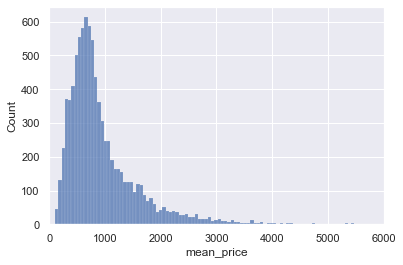

In [10]:
# show distribution to tell whether median or mean should be used as imputed value
sns.set_theme()
sns.histplot(s_master["mean_price"])
plt.xlim(0, 6000)

There are a lot of missing values (approx. 25% of the data). Hence they should rather be imputed than removed since a lot of predictive power would be missing, especially for small areas as these are the small samples. To consider for differences over time and between different dwelling types, the missing values are going to be imputed with the median of the same dwelling type and from the same quarter. The median is used since the distribution of house prices is heavily skewed to the right, thus, median reflects the center of the distribution more accurately than the mean.<br >
The missing values in sales_no column will be imputed with the value of 5. This values is assumed since it is known that samples smaller than 10 are not included due to privacy issues. Hence a value of 5 i.e. the middle of the range is a reasonable assumption.

In [11]:
# Impute na  

# na in 'sales_no': repace with 5 (median of 0 and 10)
s_master.loc[s_master['sales_no'].isnull(), 'sales_no'] = 5.0
s_master['sales_no'].isnull().any()

False

In [12]:
# na in 'median_price': replace with median of 'median_place' of the same dwelling_type of the same quarter
keys = list(s_master['key'].unique())

# Total
for k in keys:
    k_imp = s_master.loc[(s_master['median_price'].notna()) & 
                         (s_master['dwelling_type']=='Total') &
                         (s_master['key']==k),
                         'median_price'].median() # calculate imputer value 
    
    s_master.loc[(s_master['median_price'].isnull()) & 
                 (s_master['dwelling_type']=='Total') &
                 (s_master['key']==k),
                 'median_price']=k_imp #impute
    
# Strata
for k in keys:
    k_imp = s_master.loc[(s_master['median_price'].notna()) & 
                         (s_master['dwelling_type']=='Strata') &
                         (s_master['key']==k),
                         'median_price'].median()
    
    s_master.loc[(s_master['median_price'].isnull()) & 
                 (s_master['dwelling_type']=='Strata') &
                 (s_master['key']==k),
                 'median_price']=k_imp

# Non-Strata
for k in keys:
    k_imp = s_master.loc[(s_master['median_price'].notna()) & 
                         (s_master['dwelling_type']=='Non Strata') &
                         (s_master['key']==k),
                         'median_price'].median()
    
    s_master.loc[(s_master['median_price'].isnull()) & 
                 (s_master['dwelling_type']=='Non Strata') &
                 (s_master['key']==k),
                 'median_price']=k_imp

s_master['median_price'].isnull().any()

False

In [13]:
# na in 'mean_price': replace with median of 'mean_price' of the same dwelling_type of the same quarter

# Total
for k in keys:
    k_imp = s_master.loc[(s_master['mean_price'].notna()) & 
                         (s_master['dwelling_type']=='Total') &
                         (s_master['key']==k),
                         'median_price'].median() # calculate imputer value 
    
    s_master.loc[(s_master['mean_price'].isnull()) & 
                 (s_master['dwelling_type']=='Total') &
                 (s_master['key']==k),
                 'median_price']=k_imp #impute
    
# Strata
for k in keys:
    k_imp = s_master.loc[(s_master['mean_price'].notna()) & 
                         (s_master['dwelling_type']=='Strata') &
                         (s_master['key']==k),
                         'mean_price'].median()
    
    s_master.loc[(s_master['mean_price'].isnull()) & 
                 (s_master['dwelling_type']=='Strata') &
                 (s_master['key']==k),
                 'mean_price']=k_imp

# Non-Strata
for k in keys:
    k_imp = s_master.loc[(s_master['mean_price'].notna()) & 
                         (s_master['dwelling_type']=='Non Strata') &
                         (s_master['key']==k),
                         'mean_price'].median()
    
    s_master.loc[(s_master['mean_price'].isnull()) & 
                 (s_master['dwelling_type']=='Non Strata') &
                 (s_master['key']==k),
                 'mean_price']=k_imp
    
s_master['median_price'].isnull().any()

False

Sales number was read into the dataframe as string because accordingly to the Explanatory note "statistics calculated from sample sizes between 10 and 30 are shown by an ‘s’ in the relevant table.  We suggest these data are treated with caution, particularly when assessing quarterly and annual changes."

In [14]:
# Replace 's' with the median of 10 and 30 since there're quite a few
s_master.loc[s_master['sales_no'] == 's', 'sales_no'] = 20.0

# Cast type as float
s_master['sales_no'] = s_master['sales_no'].astype(float)

s_master.describe().round(2)

,postcode,median_price,mean_price,sales_no,Qdelta_median,Adelta_median,Qdelta_count,Adelta_count
count,12445.00,12445.00,11328.00,12445.00,8924.00,8919.00,8924.00,8919.00
mean,2373.63,839.16,922.64,41.47,0.03,0.05,0.17,0.24
std,256.64,567.54,687.56,48.35,0.46,0.45,0.71,0.77
min,2000.00,80.00,110.00,5.00,-0.97,-0.97,-0.72,-0.80
25%,2145.00,601.00,600.00,5.00,-0.04,-0.05,-0.17,-0.14
50%,2324.00,710.00,750.00,20.00,0.02,0.04,0.04,0.10
75%,2572.00,868.00,997.25,54.00,0.08,0.12,0.32,0.41
max,3691.00,17500.00,15897.00,418.00,29.04,26.13,32.00,13.00


In [15]:
# Separate dwelling types
s_total = s_master.loc[s_master['dwelling_type']=='Total']
s_strata = s_master.loc[s_master['dwelling_type']=='Strata']
s_nstrata = s_master.loc[s_master['dwelling_type']=='Non Strata']

print('Total:', s_total.shape,"\n",
     'Strata:', s_strata.shape,"\n",
     'Non Strata:', s_nstrata.shape)

print('Proportion of Strata estate types:\t', round(len(s_strata)/len(s_master)*100, 2), '%')
print('Proportion of Non-Strata estate types:\t', round(len(s_nstrata)/len(s_master)*100, 2), '%')
print('Proportion of Total estate types:\t', round(len(s_nstrata)/len(s_master)*100, 2), '%')

Total: (4793, 13) 
 Strata: (2893, 13) 
 Non Strata: (4759, 13)
Proportion of Strata estate types:	 23.25 %
Proportion of Non-Strata estate types:	 38.24 %
Proportion of Total estate types:	 38.24 %


### 1-2 Exploratory and descriptive analysis

#### A. <u>Total level trends - Number of houses sold</u> ####

Key observations:
* Total sales started decline in Q1 2020 when COVID first struck, reaching a low point in Jun-20
* However, bounce back was quick to come in Q3'20 and achieved a 200% growth vs. SQLY in Q4'20

To investigate more:
* Difference between Strata and Non-Strata houses - *Strata property are mostly apartment and townhouse; while non-Strata are more likely to be houses - will explain more in the price section*
* Calculate quarter-on-quarter growth rate -> show off of skills hehee

In [16]:
# Look at total number of sales by quarter and dwelling type
sales_num = s_master.groupby(['time_period', "dwelling_type"])['sales_no'].sum().unstack()

sales_num['Strata%'] = sales_num['Strata'] / (sales_num['Strata'] + sales_num['Non Strata']) * 100
sales_num['Non Strata%'] = sales_num['Non Strata'] / (sales_num['Strata'] + sales_num['Non Strata']) * 100

# recalculate total sales
sales_num["Total"] = sales_num["Non Strata"] + sales_num["Strata"]

sales_num.round(2)

dwelling_type,Non Strata,Strata,Total,Strata%,Non Strata%
time_period,,,,,
2019 Q1,13266.0,5838.0,19104.0,30.56,69.44
2019 Q2,17052.0,8438.0,25490.0,33.10,66.90
2019 Q3,17857.0,9894.0,27751.0,35.65,64.35
2019 Q4,19311.0,10310.0,29621.0,34.81,65.19
2020 Q1,16430.0,8944.0,25374.0,35.25,64.75
2020 Q2,15408.0,6233.0,21641.0,28.80,71.20
2020 Q3,23162.0,10184.0,33346.0,30.54,69.46
2020 Q4,27120.0,12770.0,39890.0,32.01,67.99
2021 Q1,23934.0,12871.0,36805.0,34.97,65.03


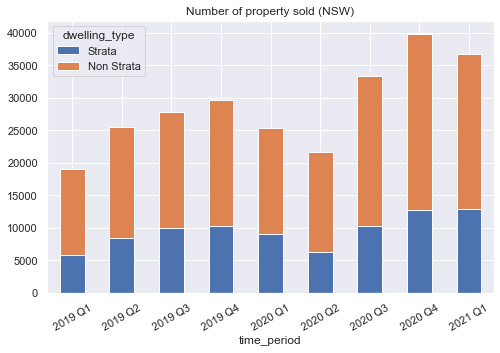

In [17]:
# Visualisation
sales_num_plot = sales_num[['Strata', 'Non Strata']]


sales_num_plot.plot(kind='bar', stacked=True,
                    title = "Number of property sold (NSW)",
                    legend=True,
                    figsize=(8,5), 
                    rot=30);


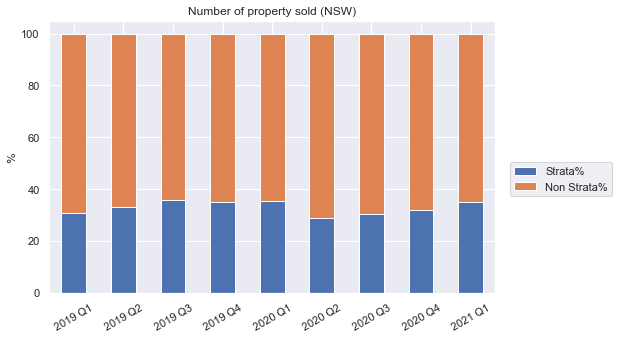

In [18]:
# stacked bar chart showing percentage changes over time
sales_num_plot = sales_num[['Strata%', 'Non Strata%']]



sales_num_plot.plot(kind='bar', 
                    stacked=True,
                    title = "Number of property sold (NSW)",
                    figsize=(8,5),
                    rot=30)
plt.xlabel("")
plt.ylabel("%")

plt.legend(bbox_to_anchor=(1.02, 0.5));

The above graphs show:
- There is an overall increasing trend in houses sold in NSW with a distinct decrease in Q1 and Q2 2020. However, number recovered fast.
- Non Strata properties make up over 60% of properties. There seems to be a slight trend towards an increasing share of Strata properties, which was reversed in Q2 2020, but seems to go on since then.

In [19]:
# Check QoQ growth
sales_num['growth_strata'] = sales_num.Strata.pct_change()*100
sales_num['growth_nstrata'] = sales_num['Non Strata'].pct_change()*100
sales_num

dwelling_type,Non Strata,Strata,Total,Strata%,Non Strata%,growth_strata,growth_nstrata
time_period,,,,,,,
2019 Q1,13266.0,5838.0,19104.0,30.559045,69.440955,NaN,NaN
2019 Q2,17052.0,8438.0,25490.0,33.103178,66.896822,44.535800,28.539123
2019 Q3,17857.0,9894.0,27751.0,35.652769,64.347231,17.255274,4.720854
2019 Q4,19311.0,10310.0,29621.0,34.806387,65.193613,4.204568,8.142465
2020 Q1,16430.0,8944.0,25374.0,35.248680,64.751320,-13.249273,-14.918958
2020 Q2,15408.0,6233.0,21641.0,28.801811,71.198189,-30.310823,-6.220329
2020 Q3,23162.0,10184.0,33346.0,30.540395,69.459605,63.388416,50.324507
2020 Q4,27120.0,12770.0,39890.0,32.013036,67.986964,25.392773,17.088334
2021 Q1,23934.0,12871.0,36805.0,34.970792,65.029208,0.790916,-11.747788


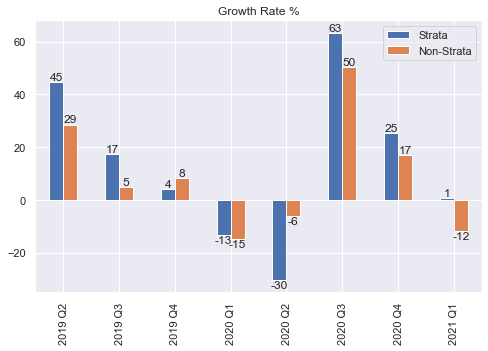

In [20]:
growth_plot = sales_num[sales_num['growth_strata'].notna()].plot.bar(use_index=True,
                                                                     y=['growth_strata','growth_nstrata'],
                                                                     title="Growth Rate %",
                                                                     figsize=(8,5),
                                                                     width = .5)
growth_plot.legend(labels=['Strata','Non-Strata'])
plt.bar_label(growth_plot.containers[0],fmt='%.f')
plt.bar_label(growth_plot.containers[1],fmt='%.f')
plt.xlabel('')
plt.show()

#### B. <u>Total level trends - average house price</u> ####
Key observations:
* Total (Strata + non-Strata) average price has been **trending up since Q1 2020** despite COVID
* And this upward trend has been **driven by non-Strata houses**, the price of which have rocketed since Q2 2020
* Strata properties (more likely to be apartment units/condos, terrace houses with shared common areas) on the contrary saw moderate increase in price in Q2'20 then falling flat

See [here](https://www.macquarie.com.au/home-loans/strata-properties-pros-and-cons.html) for more informatino on difference of Strata and non-strata property. 

**THIS IS IMPORTANT: suggesting that Strata and non-Strata house prices behave very diffirently and should probably be looked at separately in later regression analysis**

In [21]:
# Look at changes in average price
price_mean = s_master.groupby(['time_period', 'dwelling_type'])['mean_price'].mean().unstack()
price_mean.round(2)

dwelling_type,Non Strata,Strata,Total
time_period,,,
2019 Q1,849.25,750.89,842.79
2019 Q2,928.23,821.45,911.26
2019 Q3,966.24,841.71,950.79
2019 Q4,1016.61,795.46,943.41
2020 Q1,996.49,741.58,910.23
2020 Q2,965.07,783.63,918.45
2020 Q3,1024.44,767.19,929.96
2020 Q4,1070.68,779.69,964.60
2021 Q1,1152.36,794.78,997.60


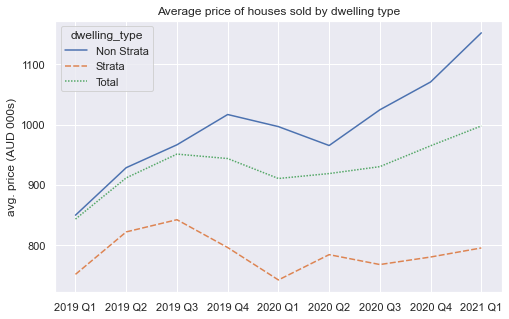

In [22]:
# Visualisation - avg. price line chart
plt.figure(figsize=(8,5))
ax = sns.lineplot(data=price_mean)
ax.set_title("Average price of houses sold by dwelling type")
ax.set_ylabel("avg. price (AUD 000s)")
ax.set_xlabel(None);

In [23]:
# Look at changes in median price to reduce the impact of potential outliers
price_median = s_master.groupby(['time_period', 'dwelling_type'])['50%_price'].mean().unstack()
price_median.round(2)

KeyError: 'Column not found: 50%_price'

In [ ]:
# Visualisation - median price line chart

plt.figure(figsize=(8,5))
ax = sns.lineplot(data=price_median)
ax.set_title("Price median of houses sold by dwelling type")
ax.set_ylabel("price (AUD 000s)")
ax.set_xlabel(None);

#### C. <u>Suburb level (Q1 2021) - hottest and most expensive suburbs</u> ####

**TO BE DONE:**
* Scrape a table somewhere online to map postcode to the name of suburbs
* Or make a decision to use the LGA tab of the raw data sheets (instead of the postcode sheet used here)
* Investigate map visualisation

In [ ]:
# Group sales number by postcode
sales_pc = s_total.groupby(['postcode','time_period'])[['sales_no']].sum().unstack()
sales_pc.columns = sales_pc.columns.droplevel() #Drop column multiindex 
sales_pc = sales_pc.sort_values(by='2021 Q1', ascending=False)

# 10 areas with most sales in Q1 2021
sales_pc.head(10)

Roughly:
* **2250**: part of Gosford LGA (Central Coast Region)
* **2155**: part of Cherrybrook LGA 
* **2540**: Culburra LGA (Illawara Region)
* **2170**: part of Liverpool LGA
* **2650**: part of Junee LGA (Murrumbidgee Region)
* **2251**: part of Wyong LGA (Central Coast Region)
* **2560**: part of Campbelltown LGA 
* **2259**: part of Wyong LGA (Central Coast Region)
* **2145**: part of Holroyd LGA 
* **2444**: part of Port Macquarie LGA (Mid North Coast Region)

Look at how the price in these areas has changed.

In [ ]:
# Filter out top5 five postcode from the total dataset
s5_list = list(sales_pc.head(5).index)
s5 = s_total.loc[s_total['postcode'].isin(s5_list)]

# Check the average sales price of each pc
s5 = s5.groupby(['time_period','postcode'])['mean_price'].mean().unstack()

In [ ]:
plt.figure(figsize=(9,6))
ax = sns.lineplot(data=s5)
ax.set_title("Average sales price of the 5 hottest areas")
ax.set_ylim(0,1200)
ax.set_ylabel("Avg. priec(AUD 000s)")
ax.set_xlabel(None)
ax.legend(loc=4);

Next, look at avergae price by postcode.

In [ ]:
# Group price (total average) by postcode
price_pc = s_total.groupby(['postcode','time_period'])[['mean_price']].mean().unstack()
price_pc.columns = price_pc.columns.droplevel() #Drop column multiindex 
price_pc = price_pc.sort_values(by='2021 Q1', ascending=False)

# Top 5 most expensive areas in Q1 2021
price_pc.head(5)

They are:
* **2220:** Hurstville & Hurstville Grove
* **2027:** Waverly LGA - Darling Point, Edgecliff & Point Piper (in
* **2092:** Manly Warringah LGA - Seafort
* **2030:** Waverly LGA - Rose Bay North, Vaucluse, Watsons Bay
* **2107:** Manly Warringah LGA - NEWPORT BEACH, AVALON, AVALON BEACH, BILGOLA, CLAREVILLE, WHALE BEACH

In [ ]:
# Visualisation
price_pc5 = price_pc.head(5)
price_pc5_tr = price_pc5.transpose()

plt.figure(figsize=(9,6))
ax = sns.lineplot(data=price_pc5_tr)
ax.set_title("Top 5 NSW postcode with highest house prices in Q1 2021")
#ax.set_ylim(0,500)
ax.set_ylabel("Avg. price (AUD 000s)")
ax.set_xlabel(None)
ax.legend(loc=0);

It is interesting that the areas with highest price (i.e. highest demand) did not see any price reduction even through the beginning of Covid.

### 1-3 Join Census Data

In [ ]:
# Read weekly income data
census_INCP = "Files/Census/POA (UR) by INCP Toal Personal Income (Weekly).csv"

incp_raw = pd.read_csv(census_INCP, skiprows=9, nrows=11142,
                       usecols=['POA (UR)', 'INCP Total Personal Income (weekly)', 'Count'])

# Rename column for easier referencing
incp_cols = {'POA (UR)':'postcode', 'INCP Total Personal Income (weekly)':'INCP_WK'}
incp_raw.rename(columns=incp_cols, inplace=True)

incp_raw.head()

In [ ]:
incp = incp_raw.groupby(['postcode','INCP_WK'])['Count'].sum().unstack()
incp

In [ ]:
# Remove the last row
incp = incp[:-1]

In [ ]:
# Clean column names
income_cols= {'$1,000-$1,249 ($52,000-$64,999)' : '$1000-1249', 
            '$1,250-$1,499 ($65,000-$77,999)' : '$1250-1499',
            '$1,500-$1,749 ($78,000-$90,999)' : '$1500-1749 ', 
            '$1,750-$1,999 ($91,000-$103,999)': '$1750-1999',
            '$1-$149 ($1-$7,799)': '$1-149', 
            '$150-$299 ($7,800-$15,599)' : '$150-299',
            '$2,000-$2,999 ($104,000-$155,999)':'$2000-2999',
            '$3,000 or more ($156,000 or more)':'>=$3000', 
            '$300-$399 ($15,600-$20,799)':'$300-399',
            '$400-$499 ($20,800-$25,999)':'$400-499', 
            '$500-$649 ($26,000-$33,799)':'$500-649',
            '$650-$799 ($33,800-$41,599)':'$650-799', 
            '$800-$999 ($41,600-$51,999)':'$800-999'}

incp.rename(columns=income_cols, inplace=True)

# Combine 'not applicable' and 'not stated' into one column
incp['total_na'] = incp['Not applicable'] + incp['Not stated']
incp = incp.drop(columns=['Not applicable', 'Not stated'], axis=1)
incp.head(1)

In [ ]:
# Remove 'NSW' in the index and cast postcode to int64
incp.reset_index(inplace=True)
incp['postcode'] = incp['postcode'].str.split(",", n=1, expand=True)[0].astype('int64')
#incp['postcode'] = incp['postcode'].astype('int64')
incp = incp.set_index('postcode')

incp.head(1)

In [ ]:
# Join INCP with sales data
s_join = s_master.join(incp, on='postcode')
s_join.head()

# 2. Rent data

<u>USAGE POTENTIALS:</u>
1. Analyse correlation of rental price and sales price 

In [ ]:
rent = "Files/Rent/Issue-135-Rent-tables-March-2021-quarter.xlsx"
rent_pc = pd.read_excel(rent, sheet_name="Postcode", na_values='-', header=7)

In [ ]:
# Rename column for easier referencing (rent)

rename_cols= {'Postcode':'postcode', 
             'Dwelling Types':'dwelling_type', 
              'Number of Bedrooms':'bed_number',
             'First Quartile Weekly Rent for New Bonds\n$': '25%_wrent_newb',
             'Median Weekly Rent for New Bonds\n$': '50%_wrent_newb', 
             'Third Quartile Weekly Rent for New Bonds\n$': "75%_wrent_newb",
             'New Bonds Lodged\nNo.' : 'new_bonds_number',
              'Total Bonds Held\nNo.': 'total_bonds_number',
             'Sales\nNo.':'sales_number'}

rent_pc.rename(columns=rename_cols,inplace=True)
rent_pc.head(5)

In [ ]:
# Check data types
rent_pc.dtypes

In [ ]:
rent_pc.loc[rent_pc['new_bonds_number'] == 's', 'new_bonds_number'] = 20.0
rent_pc.loc[rent_pc['total_bonds_number'] == 's', 'total_bonds_number'] = 20.0

rent_pc['new_bonds_number'] = rent_pc['new_bonds_number'].astype(float)
rent_pc['total_bonds_number'] = rent_pc['total_bonds_number'].astype(float)

# Check data types again
rent_pc.dtypes

In [ ]:
# Check unique values of dwelling type
rent_pc.groupby('dwelling_type').size()

In [ ]:
# Check unique values of bed_number
rent_pc.groupby('bed_number').size()

In [ ]:
# checking shape of rent_pc and null values

print(rent_pc.shape, "\n")
print(rent_pc.isnull().sum())

In [ ]:
# Check top 20 postcodes that have higest total bond number in Q1 2021
tbonds_pc = rent_pc.groupby(["postcode", "dwelling_type"])['total_bonds_number'].sum().unstack()

tbonds_pc.sort_values(by="Total", ascending = False).head(20)

In [ ]:
nbonds_pc = rent_pc.groupby(["postcode", "dwelling_type"])['new_bonds_number'].sum().unstack()
nbonds_pc.sort_values(by='Total', ascending = False).head(20)